In this notebook we will train a mini model for 10 class imagenet based on what is desribed in ResNet article 

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib

# List visible physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Physical GPUs:", gpus)

# Enable memory growth for each GPU (prevents TensorFlow from grabbing all memory)
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Could not set memory growth on {gpu}: {e}")

# List all runtime devices
print("\nRuntime devices:")
for device in device_lib.list_local_devices():
    print(device.name, "-", device.device_type)


2025-07-23 16:26:59.789413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753275419.801743  211641 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753275419.805328  211641 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753275419.815065  211641 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753275419.815087  211641 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753275419.815089  211641 computation_placer.cc:177] computation placer alr

Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Runtime devices:
/device:CPU:0 - CPU
/device:GPU:0 - GPU


I0000 00:00:1753275422.242538  211641 gpu_device.cc:2019] Created device /device:GPU:0 with 1198 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Label classes: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


I0000 00:00:1753275422.446120  211641 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1198 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-07-23 16:27:02.551306: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


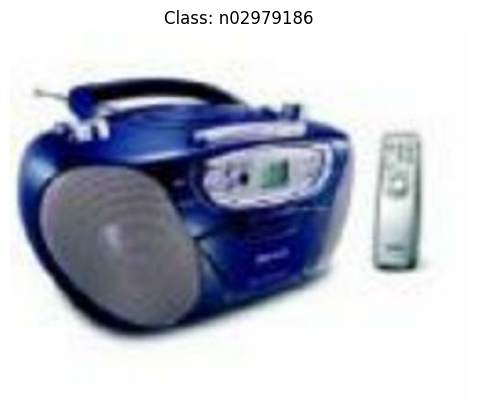

2025-07-23 16:27:02.646731: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

# Dataset name (10 ImageNet classes)
DATASET_NAME = 'imagenette/320px'  # Also available: imagenette/160px for lower resolution

# Optional: Show class names
builder = tfds.builder(DATASET_NAME)
builder.download_and_prepare()
label_names = builder.info.features['label'].names
print("Label classes:", label_names)

# Visualization
sample_ds = tfds.load(DATASET_NAME, split='train[:1%]', as_supervised=True)
for image, label in sample_ds.take(1):
    plt.imshow(image)
    plt.title(f"Class: {label_names[label.numpy()]}")
    plt.axis('off')
    plt.show()

# Preprocessing function
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def preprocess_train(img, label):
    img = tf.image.resize(img, (128, 128))
    img = data_augmentation(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label
# Splits
train_split = 'train[:80%]'
val_split = 'train[80%:]'

# Load and preprocess
train_ds = tfds.load(DATASET_NAME, split=train_split, as_supervised=True)
val_ds = tfds.load(DATASET_NAME, split=val_split, as_supervised=True)

train_ds = train_ds.map(preprocess_train).batch(16).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_train).batch(16).prefetch(tf.data.AUTOTUNE)


In [4]:

class ResNetBlock(tf.keras.Model):
    def __init__(self, filters, downsample=False):
        super().__init__()
        self.filters = filters
        self.downsample = downsample
        self.stride = 2 if downsample else 1   # with downsampling = True we reduce the dimentions by 2 

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size=1, padding="same", strides=self.stride)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv3 = tf.keras.layers.Conv2D(4*filters, kernel_size=1, padding="same", strides=1)
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.projection = None

    def build(self, input_shape):
        input_channels = input_shape[-1]
        if self.downsample or input_channels != self.filters:
            self.projection = tf.keras.layers.Conv2D(
                4*self.filters, kernel_size=3, padding="same", strides=self.stride  #kernel_size is increased to 3 
            )
        else:
            self.projection = lambda x: x

    def call(self, inputdata): 
        x = self.conv1(inputdata)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        shortcut = self.projection(inputdata)
        x = x + shortcut
        return self.relu(x)




In [14]:
# - accuracy: 0.8144 - loss: 0.5517 - val_accuracy: 0.7588 - val_loss: 0.8266 

inputs = tf.keras.Input(shape=(128, 128, 3))

x = tf.keras.layers.Conv2D(filters=16, kernel_size=7, strides=2, padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)


x = ResNetBlock(16)(inputs)
x = ResNetBlock(16)(x)
x = ResNetBlock(16)(x)

x = ResNetBlock(32, downsample=True)(x)
x = ResNetBlock(32)(x)
x = ResNetBlock(32)(x)

x = ResNetBlock(64, downsample=True)(x)
x = ResNetBlock(64)(x)
x = ResNetBlock(64)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(10, activation='softmax', dtype='float32')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/25


I0000 00:00:1753261361.922123  152479 service.cc:152] XLA service 0x7ff6800063b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753261361.922147  152479 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-07-23 12:32:42.254735: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753261363.813778  152479 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/645 ━━━━━━━━━━━━━━━━━━━━ 1:00 94ms/step - accuracy: 0.1094 - loss: 5.3475  

I0000 00:00:1753261375.841772  152479 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


645/645 ━━━━━━━━━━━━━━━━━━━━ 124s 159ms/step - accuracy: 0.2171 - loss: 2.2748 - val_accuracy: 0.3257 - val_loss: 1.9538
Epoch 2/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 88s 136ms/step - accuracy: 0.3051 - loss: 1.9491 - val_accuracy: 0.3486 - val_loss: 2.0201
Epoch 3/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 83s 129ms/step - accuracy: 0.3878 - loss: 1.7504 - val_accuracy: 0.4424 - val_loss: 1.7122
Epoch 4/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 80s 125ms/step - accuracy: 0.4626 - loss: 1.5920 - val_accuracy: 0.4172 - val_loss: 1.9296
Epoch 5/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 78s 121ms/step - accuracy: 0.4988 - loss: 1.4927 - val_accuracy: 0.4901 - val_loss: 1.6977
Epoch 6/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 78s 120ms/step - accuracy: 0.5414 - loss: 1.3660 - val_accuracy: 0.5192 - val_loss: 1.6645
Epoch 7/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 120ms/step - accuracy: 0.5798 - loss: 1.2840 - val_accuracy: 0.5983 - val_loss: 1.3392
Epoch 8/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 120ms/step - accuracy: 0.5973 - loss: 1.2156 - va

In [16]:
history = _


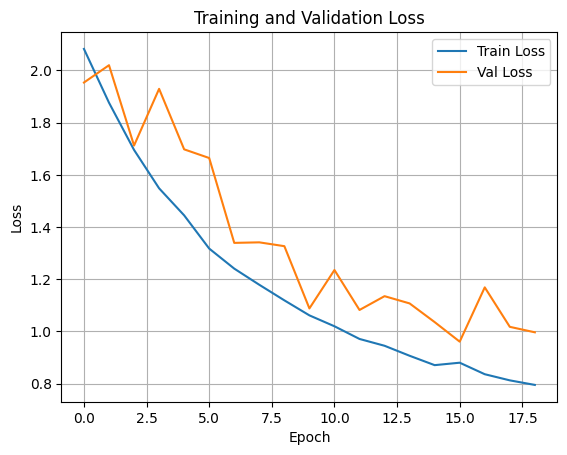

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()


In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_10 (ResNetBlock)  │ (None, 128, 128, 64)   │         5,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_11 (ResNetBlock)  │ (None, 128, 128, 64)   │        41,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_12 (ResNetBlock)  │ (None, 128, 128, 64)   │        41,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_13 (ResNetBlock)  │ (None, 64, 64, 128)    │        90,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_14 (ResNetBlock)  │ (None, 64, 64, 128)    │       165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_15 (ResNetBlock)  │ (None, 64, 64, 128)    │       165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_16 (ResNetBlock)  │ (None, 32, 32, 256)    │       358,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_17 (ResNetBlock)  │ (None, 32, 32, 256)    │       661,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_18 (ResNetBlock)  │ (None, 32, 32, 256)    │       661,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,578,768 (25.10 MB)

 Trainable params: 2,191,578 (8.36 MB)

 Non-trainable params: 4,032 (15.75 KB)

 Optimizer params: 4,383,158 (16.72 MB)

In [19]:
model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 119ms/step - accuracy: 0.7315 - loss: 0.8392 - val_accuracy: 0.6863 - val_loss: 1.0730
Epoch 2/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 119ms/step - accuracy: 0.7336 - loss: 0.8137 - val_accuracy: 0.7204 - val_loss: 0.9094
Epoch 3/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 78s 121ms/step - accuracy: 0.7408 - loss: 0.7979 - val_accuracy: 0.6948 - val_loss: 1.0217
Epoch 4/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 119ms/step - accuracy: 0.7333 - loss: 0.7994 - val_accuracy: 0.6914 - val_loss: 1.0459
Epoch 5/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 119ms/step - accuracy: 0.7378 - loss: 0.7750 - val_accuracy: 0.7018 - val_loss: 0.9562
Epoch 6/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 120ms/step - accuracy: 0.7609 - loss: 0.7526 - val_accuracy: 0.7286 - val_loss: 0.8846
Epoch 7/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 78s 120ms/step - accuracy: 0.7595 - loss: 0.7284 - val_accuracy: 0.7069 - val_loss: 0.9992
Epoch 8/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 120ms/step - accuracy: 0.7512 - loss: 0

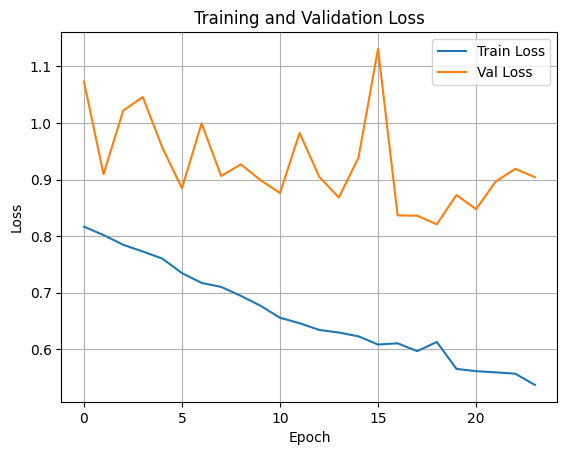

In [20]:
history = _
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()


In [21]:
model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 120ms/step - accuracy: 0.8056 - loss: 0.5872 - val_accuracy: 0.7270 - val_loss: 0.9828
Epoch 2/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 119ms/step - accuracy: 0.8166 - loss: 0.5738 - val_accuracy: 0.7387 - val_loss: 0.9634
Epoch 3/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 119ms/step - accuracy: 0.8157 - loss: 0.5809 - val_accuracy: 0.7387 - val_loss: 0.8800
Epoch 4/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 120ms/step - accuracy: 0.8154 - loss: 0.5581 - val_accuracy: 0.7390 - val_loss: 0.9124
Epoch 5/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 120ms/step - accuracy: 0.8151 - loss: 0.5586 - val_accuracy: 0.7499 - val_loss: 0.9038
Epoch 6/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 120ms/step - accuracy: 0.8144 - loss: 0.5517 - val_accuracy: 0.7588 - val_loss: 0.8266
Epoch 7/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 119ms/step - accuracy: 0.8343 - loss: 0.5137 - val_accuracy: 0.7549 - val_loss: 0.8286
Epoch 8/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 77s 120ms/step - accuracy: 0.8230 - loss: 0

In [22]:
 #- accuracy: 0.7191 - loss: 0.8628 - val_accuracy: 0.6855 - val_loss: 0.9585

inputs = tf.keras.Input(shape=(128, 128, 3))

x = tf.keras.layers.Conv2D(filters=8, kernel_size=7, strides=2, padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

x = ResNetBlock(8)(inputs)
x = ResNetBlock(8)(x)
x = ResNetBlock(8)(x)

x = ResNetBlock(16, downsample=True)(x)
x = ResNetBlock(16)(x)
x = ResNetBlock(16)(x)
x = ResNetBlock(16)(x)
x = ResNetBlock(16)(x)

x = ResNetBlock(32, downsample=True)(x)
x = ResNetBlock(32)(x)
x = ResNetBlock(32)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(10, activation='softmax', dtype='float32')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 91s 108ms/step - accuracy: 0.2331 - loss: 2.1338 - val_accuracy: 0.2036 - val_loss: 2.3675
Epoch 2/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 55s 86ms/step - accuracy: 0.3349 - loss: 1.8654 - val_accuracy: 0.2966 - val_loss: 2.0619
Epoch 3/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 56s 86ms/step - accuracy: 0.3833 - loss: 1.7505 - val_accuracy: 0.3672 - val_loss: 2.2480
Epoch 4/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.4427 - loss: 1.6283 - val_accuracy: 0.4517 - val_loss: 1.6341
Epoch 5/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.4820 - loss: 1.5374 - val_accuracy: 0.4645 - val_loss: 1.6834
Epoch 6/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.5009 - loss: 1.4775 - val_accuracy: 0.4447 - val_loss: 1.8225
Epoch 7/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.5147 - loss: 1.4271 - val_accuracy: 0.4967 - val_loss: 1.5268
Epoch 8/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.5402 - loss: 1.3746 -

In [23]:
model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 56s 86ms/step - accuracy: 0.7036 - loss: 0.9183 - val_accuracy: 0.6603 - val_loss: 1.0292
Epoch 2/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 56s 87ms/step - accuracy: 0.7099 - loss: 0.9008 - val_accuracy: 0.6976 - val_loss: 0.9329
Epoch 3/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 57s 88ms/step - accuracy: 0.7105 - loss: 0.8792 - val_accuracy: 0.6452 - val_loss: 1.1096
Epoch 4/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 67s 104ms/step - accuracy: 0.7096 - loss: 0.8794 - val_accuracy: 0.6979 - val_loss: 0.9288
Epoch 5/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 83s 129ms/step - accuracy: 0.7101 - loss: 0.8763 - val_accuracy: 0.6693 - val_loss: 1.0507
Epoch 6/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 79s 122ms/step - accuracy: 0.7260 - loss: 0.8337 - val_accuracy: 0.6448 - val_loss: 1.1272
Epoch 7/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 74s 115ms/step - accuracy: 0.7274 - loss: 0.8442 - val_accuracy: 0.6995 - val_loss: 0.9494


In [24]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_19 (ResNetBlock)  │ (None, 128, 128, 32)   │         1,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_20 (ResNetBlock)  │ (None, 128, 128, 32)   │        10,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_21 (ResNetBlock)  │ (None, 128, 128, 32)   │        10,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_22 (ResNetBlock)  │ (None, 64, 64, 64)     │        22,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_23 (ResNetBlock)  │ (None, 64, 64, 64)     │        41,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_24 (ResNetBlock)  │ (None, 64, 64, 64)     │        41,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_25 (ResNetBlock)  │ (None, 64, 64, 64)     │        41,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_26 (ResNetBlock)  │ (None, 64, 64, 64)     │        41,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_27 (ResNetBlock)  │ (None, 32, 32, 128)    │        90,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_28 (ResNetBlock)  │ (None, 32, 32, 128)    │       165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_29 (ResNetBlock)  │ (None, 32, 32, 128)    │       165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,904,312 (7.26 MB)

 Trainable params: 633,970 (2.42 MB)

 Non-trainable params: 2,400 (9.38 KB)

 Optimizer params: 1,267,942 (4.84 MB)

In [25]:
model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 65s 101ms/step - accuracy: 0.7191 - loss: 0.8628 - val_accuracy: 0.6855 - val_loss: 0.9585
Epoch 2/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 60s 93ms/step - accuracy: 0.7278 - loss: 0.8414 - val_accuracy: 0.6879 - val_loss: 0.9794
Epoch 3/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 60s 93ms/step - accuracy: 0.7264 - loss: 0.8359 - val_accuracy: 0.6720 - val_loss: 1.0221
Epoch 4/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 73s 113ms/step - accuracy: 0.7238 - loss: 0.8292 - val_accuracy: 0.6758 - val_loss: 1.0254


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_random_predictions(model, dataset, class_names=None, max_images=15):
    # Shuffle and take 15 random samples
    shuffled_ds = dataset.unbatch().shuffle(1000).take(max_images)

    plt.figure(figsize=(18, 8))

    for i, (image, label) in enumerate(shuffled_ds):
        img_batch = tf.expand_dims(image, axis=0)  # [1, H, W, C]
        prediction = model.predict(img_batch, verbose=0)[0]
        pred_label = tf.argmax(prediction).numpy()
        true_label = label.numpy()

        # Optional class name mapping
        pred_name = class_names[pred_label] if class_names else str(pred_label)
        true_name = class_names[true_label] if class_names else str(true_label)

        # Plot
        plt.subplot(3, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')
        color = "green" if pred_label == true_label else "red"
        plt.title(f"True: {true_name}\nPred: {pred_name}", color=color)

    plt.tight_layout()
    plt.show()


models are light but they do 60 - 70 acc

In [5]:
 #- - accuracy: 0.7941 - loss: 0.6315 - val_accuracy: 0.7499 - val_loss: 0.8164

inputs = tf.keras.Input(shape=(128, 128, 3))

x = tf.keras.layers.Conv2D(filters=5, kernel_size=7, strides=2, padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

x = ResNetBlock(5)(inputs)
x = ResNetBlock(5)(x)

x = ResNetBlock(10, downsample=True)(x)
x = ResNetBlock(10)(x)

x = ResNetBlock(20, downsample=True)(x)
x = ResNetBlock(20)(x)
x = ResNetBlock(20)(x)

x = ResNetBlock(40, downsample=True)(x)
x = ResNetBlock(40)(x)


x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(10, activation='softmax', dtype='float32')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)])

Epoch 1/25


I0000 00:00:1753275539.578311  211914 service.cc:152] XLA service 0x73a1f0004550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753275539.578332  211914 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-07-23 16:28:59.947057: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753275541.728867  211914 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/645 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.0556 - loss: 2.8826   

I0000 00:00:1753275553.625211  211914 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


645/645 ━━━━━━━━━━━━━━━━━━━━ 78s 85ms/step - accuracy: 0.2452 - loss: 2.1160 - val_accuracy: 0.3912 - val_loss: 1.8468
Epoch 2/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 38s 59ms/step - accuracy: 0.3842 - loss: 1.7804 - val_accuracy: 0.4502 - val_loss: 1.6215
Epoch 3/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.4611 - loss: 1.5824 - val_accuracy: 0.4595 - val_loss: 1.6509
Epoch 4/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 38s 59ms/step - accuracy: 0.5208 - loss: 1.4306 - val_accuracy: 0.5281 - val_loss: 1.4274
Epoch 5/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.5642 - loss: 1.3221 - val_accuracy: 0.5944 - val_loss: 1.2587
Epoch 6/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.5914 - loss: 1.2189 - val_accuracy: 0.5386 - val_loss: 1.4748
Epoch 7/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.6186 - loss: 1.1471 - val_accuracy: 0.5584 - val_loss: 1.3915
Epoch 8/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - accuracy: 0.6349 - loss: 1.1000 - val_accurac

In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block (ResNetBlock)     │ (None, 128, 128, 20)   │         1,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_1 (ResNetBlock)   │ (None, 128, 128, 20)   │         4,195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_2 (ResNetBlock)   │ (None, 64, 64, 40)     │         9,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_3 (ResNetBlock)   │ (None, 64, 64, 40)     │        16,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_4 (ResNetBlock)   │ (None, 32, 32, 80)     │        35,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_5 (ResNetBlock)   │ (None, 32, 32, 80)     │        65,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_6 (ResNetBlock)   │ (None, 32, 32, 80)     │        65,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_7 (ResNetBlock)   │ (None, 16, 16, 160)    │       140,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_8 (ResNetBlock)   │ (None, 16, 16, 160)    │       258,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 160)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,788,407 (6.82 MB)

 Trainable params: 595,455 (2.27 MB)

 Non-trainable params: 2,040 (7.97 KB)

 Optimizer params: 1,190,912 (4.54 MB)

In [7]:
model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)])

Epoch 1/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 39s 60ms/step - accuracy: 0.7740 - loss: 0.6880 - val_accuracy: 0.7181 - val_loss: 0.8848
Epoch 2/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.7800 - loss: 0.6636 - val_accuracy: 0.7200 - val_loss: 0.9314
Epoch 3/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.7837 - loss: 0.6617 - val_accuracy: 0.7255 - val_loss: 0.8693
Epoch 4/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - accuracy: 0.7818 - loss: 0.6562 - val_accuracy: 0.7204 - val_loss: 0.8864
Epoch 5/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - accuracy: 0.7873 - loss: 0.6439 - val_accuracy: 0.7266 - val_loss: 0.8990
Epoch 6/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 39s 60ms/step - accuracy: 0.7941 - loss: 0.6315 - val_accuracy: 0.7499 - val_loss: 0.8164
Epoch 7/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 38s 59ms/step - accuracy: 0.8030 - loss: 0.6070 - val_accuracy: 0.7352 - val_loss: 0.8701
Epoch 8/25
645/645 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.7922 - loss: 0.6131 - 

2025-07-23 16:55:09.977919: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


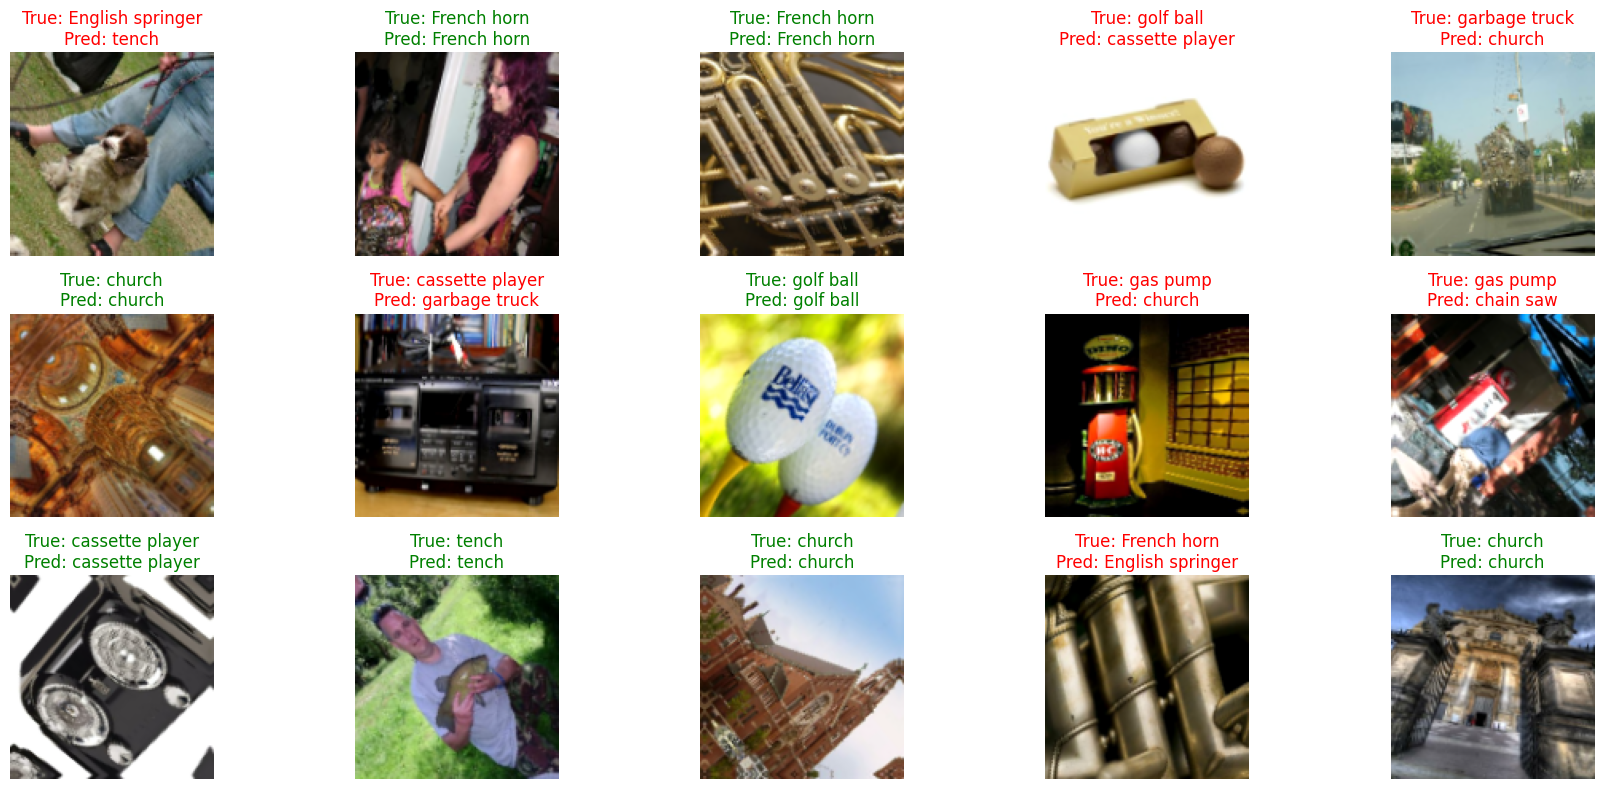

In [11]:
class_names = [
    'tench', 'English springer', 'cassette player', 'chain saw', 'church',
    'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute'
]

plot_random_predictions(model, val_ds, class_names)
